In [3]:
'''For preprocessing images'''
import numpy as np
from PIL import Image
import scipy
import matplotlib.pyplot as plt
import csv
import glob
'''For CNN'''
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
from matplotlib.pyplot import imshow

Using TensorFlow backend.


## Finetune some paramters here:

In [4]:
image_size = 96
train_data_size = 4000
test_data_size = 1000
process = lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x

In [5]:
def standardize(img):
    # padding
    longer_side = max(img.size)
    horizontal_padding = (longer_side - img.size[0]) / 2
    vertical_padding = (longer_side - img.size[1]) / 2
    img = img.crop(
        (
            -horizontal_padding,
            -vertical_padding,
            img.size[0] + horizontal_padding,
            img.size[1] + vertical_padding
        )
    )
    # resizing to standardized size
    img = img.resize([image_size,image_size],Image.ANTIALIAS) \
    # plt.imshow(img) # To see the image being standardized.
    
    # converting image to numpy array
    img.load()
    img = np.asarray(img, dtype="int32")
    return img

In [6]:
def function():
    for filename in glob.glob('input/subset_data/train/*.tif'):
        img =Image.open(filename)
        img = standardize(img)
        print(img.shape)
        return

In [7]:
function()

(96, 96, 3)


In [8]:
'''Loading data'''
def get_id_from_filename(filename):
    id = filename.split("/")[-1]
    id = id.split(".")[0]
    return id

## Edit Code:
- If number of training example changes

In [13]:
def load_train():
    names = []
    # Change first number base on number of training examples
    X_train = np.empty((train_data_size,image_size,image_size,3))
    Y_train = np.empty(shape=(train_data_size,1))

    i = 0
    for filename in glob.glob('input/subset_data/train/*.tif'):
        names.append(get_id_from_filename(filename))
        img = Image.open(filename)
        img.load()
        img =np.asarray(img)
        img = process(img)
        X_train[i-1] = img
        i += 1
        
    with open('input/subset_data/train_labels_full.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)
        for row in readCSV:
            name = row[0]
            if name in names:
                label = int(row[1])
                if label == 0:
                    Y_train[names.index(name)] = np.array([0]) # means 0
                elif label == 1:
                    Y_train[names.index(name)] = np.array([1]) # means 1
    return X_train,Y_train

## Edit Code:
- If number of training example changes

In [14]:
def load_test():
    names = []
    # Change first number base on number of training examples
    X_test = np.empty((test_data_size,image_size,image_size,3))
    Y_test = np.empty(shape=(test_data_size,1))

    i = 0
    for filename in glob.glob('input/subset_data/test_with_outputs/*.tif'):
        names.append(get_id_from_filename(filename))
        img = Image.open(filename)
        img.load()
        img =np.asarray(img)
        img = process(img)
        X_test[i-1] = img
        i += 1
        
    with open('input/subset_data/train_labels_full.csv') as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        next(readCSV, None)
        for row in readCSV:
            name = row[0]
            if name in names:
                label = int(row[1])
                if label == 0:
                    Y_test[names.index(name)] = np.array([0]) # means 0
                elif label == 1:
                    Y_test[names.index(name)] = np.array([1]) # means 1
    return X_test,Y_test

In [15]:
X_train,Y_train = load_train()
X_test,Y_test = load_test()

print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (4000, 96, 96, 3)
Y_train shape:  (4000, 1)
X_test shape:  (1000, 96, 96, 3)
Y_test shape:  (1000, 1)


In [18]:
# To check values inside.
# print(X_train)
# print(Y_train)
# print(X_test)
# print(Y_test)

In [19]:
def TrainingModel(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (4, 4), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((8, 8), name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(16, (2, 2), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='trainingModel')

    return model

In [20]:
trainingModel = TrainingModel((X_train.shape[1],X_train.shape[2],X_train.shape[3]))

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
trainingModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 102, 102, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 99, 99, 8)         392       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 99, 99, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 99, 99, 8)         0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 12, 12, 8)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 11, 11, 16)        528       
__________

In [22]:
trainingModel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
# trainingModel.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Simple CNN

In [23]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

trainingModel.fit(x = X_train, y = Y_train, epochs = 50, batch_size = 32, validation_data=(X_test,Y_test),callbacks=[reducel, earlystopper])

Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 3s 832us/step - loss: 0.7338 - acc: 0.5465 - val_loss: 0.7068 - val_acc: 0.5290
Epoch 2/50
4000/4000 [==============================] - 2s 456us/step - loss: 0.6923 - acc: 0.5697 - val_loss: 0.6849 - val_acc: 0.5840
Epoch 3/50
4000/4000 [==============================] - 2s 463us/step - loss: 0.6813 - acc: 0.5827 - val_loss: 0.6805 - val_acc: 0.5960
Epoch 4/50
4000/4000 [==============================] - 2s 448us/step - loss: 0.6722 - acc: 0.5855 - val_loss: 0.6947 - val_acc: 0.5510

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/50
4000/4000 [==============================] - 2s 452us/step - loss: 0.6578 - acc: 0.6130 - val_loss: 0.6863 - val_acc: 0.5780

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch
Epoch

In [24]:
preds = trainingModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 0s 210us/step

Loss = 0.6804630780220031
Test Accuracy = 0.596


## A deeper CNN
https://towardsdatascience.com/image-classification-python-keras-tutorial-kaggle-challenge-45a6332a58b8
## 5 ways to improve model:
- adding more dropout layers (for overfitting)
- experiment with removing or adding convolutional layers, changing the filter size, or even changing the activation functions

In [20]:
model = Sequential()

model.add(ZeroPadding2D((3, 3)))

model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # newly added

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # newly added

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # newly added

model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # newly added

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))  # newly added
model.add(Dense(2, activation = 'softmax'))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [24]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

model.fit(x = X_train, y = Y_train, epochs = 50, batch_size = 32, validation_data=(X_test,Y_test),callbacks=[reducel, earlystopper])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 8s 2ms/step - loss: 0.7421 - acc: 0.5410 - val_loss: 0.7071 - val_acc: 0.5830
Epoch 2/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7098 - acc: 0.5563 - val_loss: 0.6853 - val_acc: 0.5810
Epoch 3/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.7047 - acc: 0.5610 - val_loss: 0.6929 - val_acc: 0.5990

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6916 - acc: 0.5722 - val_loss: 0.6828 - val_acc: 0.6000
Epoch 5/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6869 - acc: 0.5655 - val_loss: 0.6806 - val_acc: 0.6000
Epoch 6/50
4000/4000 [===============

In [25]:
preds = model.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 0s 433us/step

Loss = 0.6790213828086853
Test Accuracy = 0.603


In [26]:
y_pred = model.predict(X_test)
[print(y) for y in y_pred] 
#[print(y) for y in Y_test] 

[0.60629666 0.39370334]
[0.58662933 0.41337067]
[0.6395826  0.36041746]
[0.6382677  0.36173227]
[0.5860308  0.41396922]
[0.5733769 0.4266231]
[0.59028447 0.40971553]
[0.5977267  0.40227324]
[0.5842048  0.41579524]
[0.5777173  0.42228267]
[0.6226528 0.3773472]
[0.63128674 0.36871323]
[0.58917123 0.41082874]
[0.6441915  0.35580847]
[0.5798311  0.42016885]
[0.6454003  0.35459968]
[0.58825976 0.41174024]
[0.61114013 0.38885987]
[0.57965535 0.42034465]
[0.61013377 0.38986623]
[0.6490514  0.35094854]
[0.6396956 0.3603044]
[0.5911095  0.40889052]
[0.6543318  0.34566817]
[0.5995446  0.40045547]
[0.62875235 0.37124768]
[0.58687663 0.41312337]
[0.60828644 0.39171353]
[0.5927745  0.40722546]
[0.5852055  0.41479447]
[0.5805594  0.41944066]
[0.60588443 0.3941156 ]
[0.52390116 0.4760988 ]
[0.5261471  0.47385287]
[0.65912455 0.34087548]
[0.5885878 0.4114122]
[0.6469986  0.35300142]
[0.6501294 0.3498706]
[0.626263   0.37373692]
[0.64040583 0.35959414]
[0.60599995 0.39400002]
[0.5971629 0.4028371]
[0.5

[0.5783355  0.42166448]
[0.5705706 0.4294294]
[0.61666167 0.38333836]
[0.5975467  0.40245327]
[0.59602755 0.40397245]
[0.5843053  0.41569474]
[0.6142188  0.38578123]
[0.63540965 0.36459032]
[0.5990054  0.40099466]
[0.5453496  0.45465037]
[0.5937414  0.40625855]
[0.59955674 0.40044323]
[0.5803115  0.41968855]
[0.64674497 0.35325503]
[0.55091983 0.4490802 ]
[0.63279855 0.36720145]
[0.56628656 0.43371347]
[0.59596306 0.40403694]
[0.5898951  0.41010493]
[0.59510833 0.4048916 ]
[0.5835392 0.4164608]
[0.6088137  0.39118633]
[0.5548956  0.44510442]
[0.63979036 0.36020964]
[0.6531707 0.3468293]
[0.6299602  0.37003985]
[0.5804632  0.41953683]
[0.6518505  0.34814954]
[0.65456396 0.34543607]
[0.60096383 0.39903614]
[0.6478927  0.35210732]
[0.58825374 0.4117462 ]
[0.6330654  0.36693454]
[0.5950046  0.40499544]
[0.60088295 0.3991171 ]
[0.5206546 0.4793454]
[0.6289464  0.37105358]
[0.6514885  0.34851152]
[0.62679595 0.37320402]
[0.6217928  0.37820724]
[0.6374437 0.3625563]
[0.64625037 0.35374966]
[0

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [27]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
y_pred = model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test[:, 1], y_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.4410042297035015

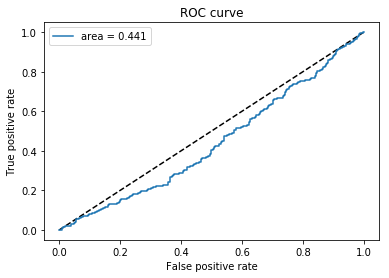

In [28]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## VGG16

In [93]:
vgg16_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False)

In [94]:
# checking the type
type(vgg16_model)

keras.engine.training.Model

In [96]:
# Freeze some layers
for layer in vgg16_model.layers[:20]:
    layer.trainable = False

In [97]:
# Create your own input format 
X_input = Input(shape=(image_size,image_size,3),name = 'image_input')

In [98]:
output_vgg16_conv = vgg16_model(X_input)

In [99]:
# Add the fully-connected layers 
X = Flatten(name='flatten')(output_vgg16_conv)
X = Dense(2048, activation='relu', name='fc1')(X)
X = Dense(2048, activation='relu', name='fc2')(X)
X = Dense(2, activation='softmax', name='predictions')(X)

In [100]:
my_model = Model(inputs=X_input, outputs=X,name='myModel')

In [101]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 96, 96, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 2048)              9439232   
_________________________________________________________________
fc2 (Dense)                  (None, 2048)              4196352   
_________________________________________________________________
predictions (Dense)          (None, 2)                 4098      
Total params: 28,354,370
Trainable params: 13,639,682
Non-trainable params: 14,714,688
_______________________________________________________

In [102]:
# my_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
my_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [103]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

model.fit(X_train, Y_train, batch_size = 32, epochs = 50, verbose = 1, validation_data=(X_test,Y_test),callbacks=[reducel, earlystopper])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 6s 2ms/step - loss: 0.6877 - acc: 0.5640 - val_loss: 0.6744 - val_acc: 0.6080
Epoch 2/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6879 - acc: 0.5740 - val_loss: 0.6745 - val_acc: 0.6090

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 3/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6839 - acc: 0.5750 - val_loss: 0.6746 - val_acc: 0.6090

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Restoring model weights from the end of the best epoch
Epoch 00003: early stopping


In [104]:
preds = my_model.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 3s 3ms/step
Loss = 0.7675437154769897
Test Accuracy = 0.421


## InceptionV3

In [105]:
inceptionV3_model = keras.applications.inception_v3.InceptionV3(weights='imagenet',include_top=False)

In [106]:
type(inceptionV3_model)

keras.engine.training.Model

In [107]:
# Freeze all the other layers, let last few layers to be trainable
for layer in inceptionV3_model.layers[:290]:
    layer.trainable = False

In [108]:
# Create your own input format
X_input = Input(shape=(image_size,image_size,3),name = 'image_input')

In [109]:
output_inceptionV3_conv = inceptionV3_model(X_input)

In [110]:
# keras recommended application
X = GlobalAveragePooling2D()(output_inceptionV3_conv)
X = Dense(1024, activation='relu')(X)
X = Dense(2, activation='softmax', name='predictions')(X)

In [111]:
my_model = Model(inputs=X_input, outputs=X,name='myModel')

In [112]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 96, 96, 3)         0         
_________________________________________________________________
inception_v3 (Model)         multiple                  21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
predictions (Dense)          (None, 2)                 2050      
Total params: 23,903,010
Trainable params: 4,477,954
Non-trainable params: 19,425,056
_________________________________________________________________


In [113]:
my_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [114]:
print(Y_test.shape)
print(Y_train.shape)

(1000, 2)
(4000, 2)


In [115]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)

model.fit(X_train, Y_train, batch_size = 32, epochs = 50, verbose = 1, validation_data=(X_test,Y_test),callbacks=[reducel, earlystopper])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 10s 2ms/step - loss: 0.6853 - acc: 0.5800 - val_loss: 0.6745 - val_acc: 0.6090
Epoch 2/50
4000/4000 [==============================] - 6s 1ms/step - loss: 0.6860 - acc: 0.5677 - val_loss: 0.6745 - val_acc: 0.6090

Epoch 00002: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 3/50
4000/4000 [==============================] - 6s 1ms/step - loss: 0.6854 - acc: 0.5733 - val_loss: 0.6745 - val_acc: 0.6090

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.
Epoch 4/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6845 - acc: 0.5847 - val_loss: 0.6744 - val_acc: 0.6090

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
Epoch 5/50
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6826 - acc: 0.5763 - val_loss: 0.6745 - val_acc: 0.6090

Epoch 00005: ReduceLROnPlateau reduci

In [116]:
preds = my_model.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 5s 5ms/step
Loss = 0.842498948097229
Test Accuracy = 0.54


## Resnet50

In [26]:
from keras.applications.resnet50 import ResNet50

dropout_fc = 0.5

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (image_size,image_size,3))

my_model = Sequential()

my_model.add(conv_base)
my_model.add(Flatten())
my_model.add(Dense(256, use_bias=False))
my_model.add(BatchNormalization())
my_model.add(Activation("relu"))
my_model.add(Dropout(dropout_fc))
my_model.add(Dense(1, activation = "sigmoid"))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [27]:
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718592   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_52 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

In [28]:
conv_base.Trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name == 'res5a_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [29]:
from keras import optimizers
my_model.compile(optimizers.Adam(0.001), loss = "binary_crossentropy", metrics = ["accuracy"])

In [30]:
# Create your own input format 
X_input = Input(shape=(image_size,image_size,3),name = 'image_input')

In [31]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
my_model.fit(x = X_train, y = Y_train, epochs = 9, batch_size = 32, validation_data=(X_test,Y_test), callbacks=[reducel, earlystopper])

Train on 4000 samples, validate on 1000 samples
Epoch 1/9
4000/4000 [==============================] - 29s 7ms/step - loss: 0.7645 - acc: 0.5683 - val_loss: 0.8444 - val_acc: 0.6040
Epoch 2/9
4000/4000 [==============================] - 20s 5ms/step - loss: 0.7197 - acc: 0.5893 - val_loss: 0.6990 - val_acc: 0.6090
Epoch 3/9
4000/4000 [==============================] - 20s 5ms/step - loss: 0.7109 - acc: 0.6287 - val_loss: 0.7313 - val_acc: 0.6050

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/9
4000/4000 [==============================] - 20s 5ms/step - loss: 0.5869 - acc: 0.7645 - val_loss: 0.6934 - val_acc: 0.5970
Epoch 5/9
4000/4000 [==============================] - 20s 5ms/step - loss: 0.4870 - acc: 0.8342 - val_loss: 0.6958 - val_acc: 0.5700

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 6/9
4000/4000 [==============================] - 20s 5ms/step - loss: 0.3479 - acc: 0.9073 - val_loss: 0.7110 - 

In [32]:
preds = my_model.evaluate(x = X_test, y = Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 2s 2ms/step
Loss = 0.6934362449645997
Test Accuracy = 0.597


In [33]:
[print(y) for y in my_model.predict(X_test)] 

[0.4212867]
[0.39174595]
[0.40390238]
[0.44005755]
[0.47084934]
[0.46770692]
[0.4108221]
[0.42734474]
[0.40130153]
[0.3452026]
[0.48712403]
[0.4731412]
[0.3202902]
[0.44441465]
[0.43910733]
[0.34190598]
[0.11323726]
[0.41759244]
[0.5709752]
[0.39542255]
[0.3655085]
[0.47389412]
[0.46512574]
[0.35545385]
[0.40793008]
[0.40201706]
[0.45595586]
[0.35429484]
[0.479266]
[0.47018456]
[0.40247732]
[0.3798739]
[0.5182965]
[0.49371335]
[0.4358311]
[0.271375]
[0.4353197]
[0.45108572]
[0.2896011]
[0.4419379]
[0.42984664]
[0.3538571]
[0.3932947]
[0.3970685]
[0.43353403]
[0.38597813]
[0.4783542]
[0.42155045]
[0.43813664]
[0.5548589]
[0.38224393]
[0.4982891]
[0.42245302]
[0.5122288]
[0.51347303]
[0.43237334]
[0.49999604]
[0.3769383]
[0.37840107]
[0.43985358]
[0.4072265]
[0.44003513]
[0.366679]
[0.46471685]
[0.57139415]
[0.49822474]
[0.5102014]
[0.40480825]
[0.39880988]
[0.45250043]
[0.46101874]
[0.48507243]
[0.38802013]
[0.4830412]
[0.3177153]
[0.2808095]
[0.30457067]
[0.33799797]
[0.31234336]
[0.44

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [56]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
y_pred = my_model.predict(X_test)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test[:, 1], y_pred[:,1])
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

0.49828338594262855

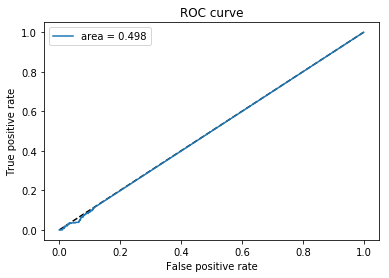

In [57]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()